# Data Preparation and PCA Visualization

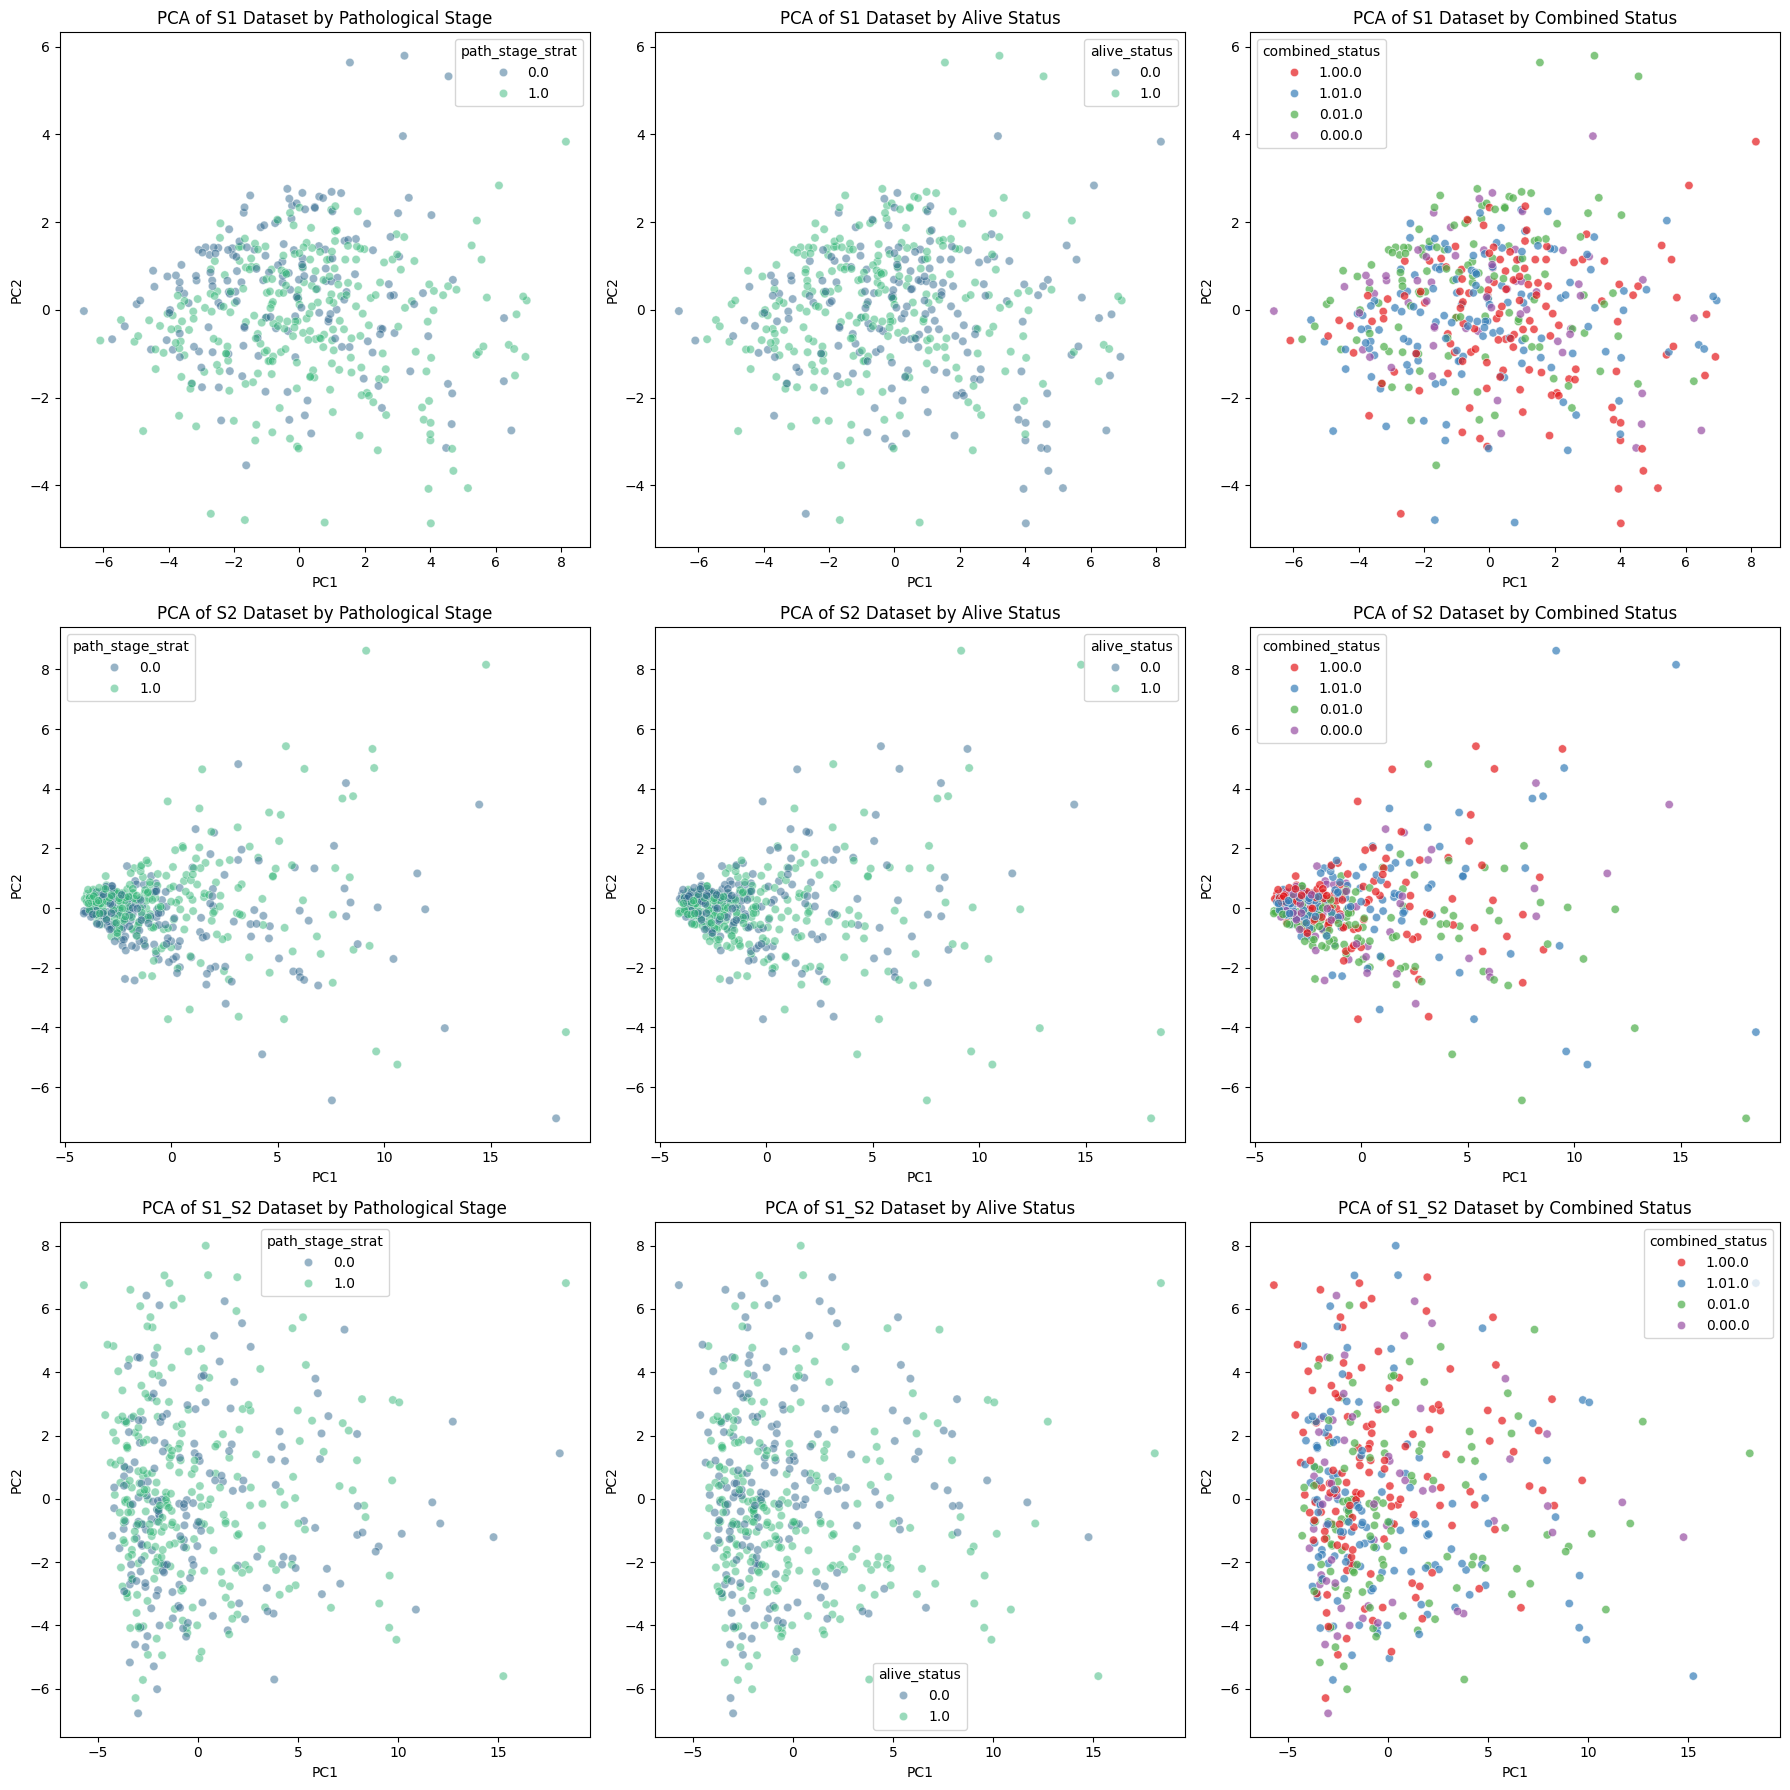

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clinical_df = pd.read_csv('data/clinical.tsv', sep='\t')
clinical_df['path_stage_strat'] = clinical_df['ajcc_pathologic_stage'].replace("'--", np.NaN).map({'Stage I': 0, 'Stage II': 0, 'Stage III': 0, 'Stage IVA': 1, 'Stage IVB': 1, 'Stage IVC': 1})
conditions = [
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*3),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*3) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*5),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*5) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*10),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*10) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*20),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*20),
    (clinical_df['days_to_death'] == "'--") | (clinical_df['days_to_death'].isna())
]
values = [0, 0, 0, 0, 0, 0, 1]
clinical_df['alive_status'] = np.select(conditions, values)
clinical_df = clinical_df[['case_submitter_id', 'path_stage_strat', 'alive_status']]

file_to_case_df = pd.read_csv('data/new_file_to_case.tsv', sep='\t')
data_files = ['data/new_rnaseq_s1.tsv', 'data/new_rnaseq_s2.tsv', 'data/new_rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']

fig, axes = plt.subplots(3, 3, figsize=(18, 18)) 

for idx, (data_file, name) in enumerate(zip(data_files, data_frame_names)):
    df = pd.read_csv(data_file, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_submitter_id', how='left').dropna()
    
    df['combined_status'] = df['path_stage_strat'].astype(str) + df['alive_status'].astype(str)
    
    X = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, df[['path_stage_strat', 'alive_status', 'combined_status']].reset_index(drop=True)], axis=1)
    
    col = idx % 3

    sns.scatterplot(ax=axes[col, 0], x='PC1', y='PC2', hue='path_stage_strat', data=finalDf, palette='viridis', alpha=0.5)
    axes[col, 0].set_title(f'PCA of {name} Dataset by Pathological Stage')

    sns.scatterplot(ax=axes[col, 1], x='PC1', y='PC2', hue='alive_status', data=finalDf, palette='viridis', alpha=0.5)
    axes[col, 1].set_title(f'PCA of {name} Dataset by Alive Status')
    
    sns.scatterplot(ax=axes[col, 2], x='PC1', y='PC2', hue='combined_status', data=finalDf, palette='Set1', alpha=0.7)
    axes[col, 2].set_title(f'PCA of {name} Dataset by Combined Status')

plt.tight_layout()
plt.show()

This section loads clinical data, stratifies it according to pathological stages and alive status, and then merges it with RNA-seq datasets. The data is standardized and processed through Principal Component Analysis (PCA) for dimensionality reduction. Subsequent scatter plots visualize the PCA results, categorized by pathological stage, alive status, and a combined status, in a 3x3 grid layout for the datasets S1, S2, and S1_S2.

In [3]:
alive_status = clinical_df['alive_status'].value_counts().sort_index()
print(alive_status)

0    223
1    304
Name: alive_status, dtype: int64


Here, we are calculating the distribution of alive statuses in the clinical dataset to understand the balance or imbalance within the data.

In [4]:
path_stage_strat = clinical_df['path_stage_strat'].value_counts().sort_index()
print(path_stage_strat)

0.0    182
1.0    270
Name: path_stage_strat, dtype: int64


This part of the code is dedicated to reporting the counts of different pathological stages in the data, which is essential for assessing the staging distribution and planning stratified analyses. 0 is for Stage 1-3. 1 if for the rest.

# Machine Learning with XGBoost

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data_files = ['data/new_rnaseq_s1_s2.tsv']
data_frame_names = ['S1_S2']

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Results for dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_submitter_id', how='left').dropna()

    X = MinMaxScaler().fit_transform(df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status']))
    y = df['alive_status'].values 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    print(f"Accuracy for {dataset_name}: {accuracy:.4f}\n")


Results for dataset S1_S2:
Accuracy for S1_S2: 0.5169



We utilize the machine learning library XGBoost to create a predictive model using the RNA-seq S1_S2 combined dataset. After preprocessing, scaling, and splitting the data, we train an XGBoost classifier and evaluate its accuracy.

# Autoencoder

Processing dataset S1_S2:
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy for S1_S2: 0.6292



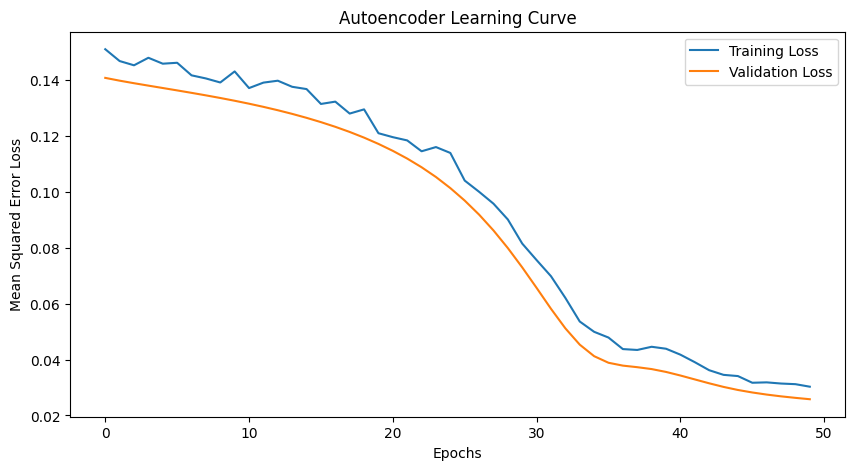

In [45]:
from keras.models import Model
from keras.layers import Input, Dense,Dropout
from keras.regularizers import l1

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Processing dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_submitter_id', how='left').dropna()

    X = df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
    y = df['alive_status'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    input_img = Input(shape=(X_train_scaled.shape[1],))
    encoded = Dense(40, activation='relu', activity_regularizer=l1(1e-5))(input_img)
    encoded = Dropout(0.1)(encoded) 
    encoded = Dense(30, activation='relu', activity_regularizer=l1(1e-5))(encoded)
    encoded = Dropout(0.1)(encoded)  
    encoded = Dense(20, activation='relu', activity_regularizer=l1(1e-5))(encoded)
    encoded = Dropout(0.1)(encoded) 
    encoded = Dense(10, activation='relu', activity_regularizer=l1(1e-5))(encoded)
    decoded = Dense(20, activation='relu')(encoded)
    decoded = Dense(30, activation='relu')(encoded)
    decoded = Dense(40, activation='relu')(decoded)
    decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    history = autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

    X_train_encoded = encoder.predict(X_train_scaled)
    X_test_encoded = encoder.predict(X_test_scaled)

    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    classifier.fit(X_train_encoded, y_train)

    y_pred = classifier.predict(X_test_encoded)
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_name}: {overall_accuracy:.4f}\n")
    
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()


In this script, we build an autoencoder neural network for the purpose of feature reduction. This model is trained on RNA-seq data and is followed by the application of an XGBoost classifier to the encoded features. The model's accuracy is printed, and the training and validation losses are plotted to assess the learning process.

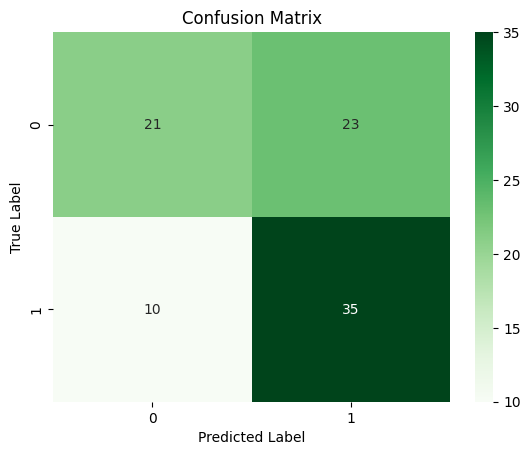

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


We visualize the performance of our classifier by displaying a confusion matrix using a heatmap. This matrix helps to identify the true positives, true negatives, false positives, and false negatives in the predictions.


# ROC Curve Analysis

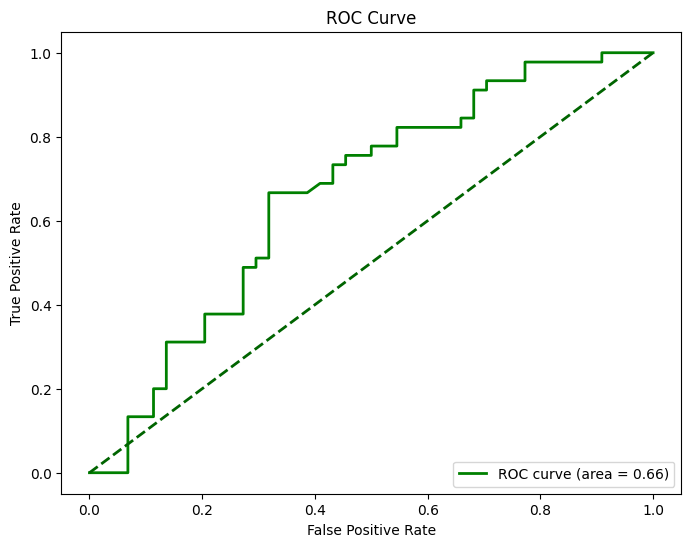

In [54]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = classifier.predict_proba(X_test_encoded)

fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1]) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgreen', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The choice was made to use the ROC Curve because the data data was essentially the same for dead and alive data.

This section includes code to evaluate the performance of a machine learning classifier. The classifier's predicted probabilities are used to construct a Receiver Operating Characteristic (ROC) curve. This graph is a tool used to assess the quality of a binary classification model by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

The area under the ROC curve (AUC) is calculated to quantify the overall ability of the model to discriminate between the positive and negative classes. A perfect classifier would have an AUC of 1.0, while a purely random classifier would have an AUC of 0.5.